# scANVI integration of disease dataset
- Reran scvi without study as a categorical covariate as this currently isn't handled by scArches 
'''./run_scvi_adsaves.py --n-hvg 7500 \
            --remove-from-hvg feature_list/cc_genes.csv \
            --batch donorID_unified \
            --min-batch-size 0 \
            --continuous log1p_n_counts,percent_mito \
            --train-reference \
            ~/Annotations_v3/pooled_healthy.gene_cellbender.good_qc_cluster_mito80.raw.subsetted.manual_doublet_removed.fine_annot.20230110.h5ad \
            ~/Annotations_v3/scvi_output20230116/pooled_healthy.hvg7500_noCC.nodoublets.scvi_output.20230113
- Then used this notebook (from Ni) to run scANVI 
- Adapt predictions to run from KNN graph rather than genes based on HLCA code: https://github.com/LungCellAtlas/HLCA_reproducibility/blob/main/scripts/label_transfer.py


# Import and settings

In [13]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib

import numpy as np
import numpy_groupies as npg
import scipy.sparse as sp
import pandas as pd
from sklearn.preprocessing import minmax_scale

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap, LogNorm

import seaborn as sn

import anndata

import scanpy as sc
import sctk as sk

import torch
import scvi


from collections import Counter

import numpy as np
from sklearn.neighbors import KNeighborsTransformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)
sc.settings.verbosity = 0
sk.set_figsize((4, 4))
#torch.cuda.set_device(1)

#PYTHON = "/software/team205/miniconda3/envs/rapids-torch/bin/python"

#%cd ~/scratch/20220125_digestive_tract_integration/v2/

# Define functions

In [15]:
def weighted_knn_trainer(train_adata, train_adata_emb, label_key, n_neighbors=50):
    """Trains a weighted KNN classifier on ``train_adata``.
    Parameters
    ----------
    train_adata: :class:`~anndata.AnnData`
        Annotated dataset to be used to train KNN classifier with ``label_key`` as the target variable.
    train_adata_emb: str
        Name of the obsm layer to be used for calculation of neighbors. If set to "X", anndata.X will be
        used
    label_key: str
        Name of the column to be used as target variable (e.g. cell_type) in ``train_adata`` and ``query_adata``.
    n_neighbors: int
        Number of nearest neighbors in KNN classifier.
    """
    print(
        f"Weighted KNN with n_neighbors = {n_neighbors} ... ",
        end="",
    )
    k_neighbors_transformer = KNeighborsTransformer(
        n_neighbors=n_neighbors,
        mode="distance",
        algorithm="brute",
        metric="euclidean",
        n_jobs=-1,
    )
    if train_adata_emb == "X":
        train_emb = train_adata.X
    elif train_adata_emb in train_adata.obsm.keys():
        train_emb = train_adata.obsm[train_adata_emb]
    else:
        raise ValueError(
            "train_adata_emb should be set to either 'X' or the name of the obsm layer to be used!"
        )
    k_neighbors_transformer.fit(train_emb)
    return k_neighbors_transformer

In [16]:
def weighted_knn_transfer(
    query_adata,
    query_adata_emb,
    ref_adata_obs,
    label_keys,
    knn_model,
    threshold=1,
    pred_unknown=False,
    mode="package",
):
    """Annotates ``query_adata`` cells with an input trained weighted KNN classifier.
    Parameters
    ----------
    query_adata: :class:`~anndata.AnnData`
        Annotated dataset to be used to queryate KNN classifier. Embedding to be used
    query_adata_emb: str
        Name of the obsm layer to be used for label transfer. If set to "X",
        query_adata.X will be used
    ref_adata_obs: :class:`pd.DataFrame`
        obs of ref Anndata
    label_keys: str
        Names of the columns to be used as target variables (e.g. cell_type) in ``query_adata``.
    knn_model: :class:`~sklearn.neighbors._graph.KNeighborsTransformer`
        knn model trained on reference adata with weighted_knn_trainer function
    threshold: float
        Threshold of uncertainty used to annotating cells as "Unknown". cells with
        uncertainties higher than this value will be annotated as "Unknown".
        Set to 1 to keep all predictions. This enables one to later on play
        with thresholds.
    pred_unknown: bool
        ``False`` by default. Whether to annotate any cell as "unknown" or not.
        If `False`, ``threshold`` will not be used and each cell will be annotated
        with the label which is the most common in its ``n_neighbors`` nearest cells.
    mode: str
        Has to be one of "paper" or "package". If mode is set to "package",
        uncertainties will be 1 - P(pred_label), otherwise it will be 1 - P(true_label).
    """
    if not type(knn_model) == KNeighborsTransformer:
        raise ValueError(
            "knn_model should be of type sklearn.neighbors._graph.KNeighborsTransformer!"
        )

    if query_adata_emb == "X":
        query_emb = query_adata.X
    elif query_adata_emb in query_adata.obsm.keys():
        query_emb = query_adata.obsm[query_adata_emb]
    else:
        raise ValueError(
            "query_adata_emb should be set to either 'X' or the name of the obsm layer to be used!"
        )
    top_k_distances, top_k_indices = k_neighbors_transformer.kneighbors(X=query_emb)

    stds = np.std(top_k_distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)

    top_k_distances_tilda = np.exp(-np.true_divide(top_k_distances, stds))

    weights = top_k_distances_tilda / np.sum(
        top_k_distances_tilda, axis=1, keepdims=True
    )
    cols = ref_adata_obs.columns[ref_adata_obs.columns.str.startswith(label_keys)]
    uncertainties = pd.DataFrame(columns=cols, index=query_adata.obs_names)
    pred_labels = pd.DataFrame(columns=cols, index=query_adata.obs_names)
    for i in range(len(weights)):
        for j in cols:
            y_train_labels = ref_adata_obs[j].values
            unique_labels = np.unique(y_train_labels[top_k_indices[i]])
            best_label, best_prob = None, 0.0
            for candidate_label in unique_labels:
                candidate_prob = weights[
                    i, y_train_labels[top_k_indices[i]] == candidate_label
                ].sum()
                if best_prob < candidate_prob:
                    best_prob = candidate_prob
                    best_label = candidate_label

            if pred_unknown:
                if best_prob >= threshold:
                    pred_label = best_label
                else:
                    pred_label = "Unknown"
            else:
                pred_label = best_label

            if mode == "package":
                uncertainties.iloc[i][j] = (max(1 - best_prob, 0))

            else:
                raise Exception("Inquery Mode!")

            pred_labels.iloc[i][j] = (pred_label)

    print("finished!")

    return pred_labels, uncertainties

# Load data

In [17]:
ad_output = sc.read_h5ad('/home/jupyter/Annotations_v3/scvi_output20230126/pooled_healthy.hvg7500_noCC.nodoublets.scvi_output.20230126-ad1.h5ad')

In [18]:
adata = sc.read_h5ad('/home/jupyter/Annotations_v3/h5ad/post_scvi20230126/pooled_healthy.hvg7500_noCC.scvi_output_nocatcovar.fine_annot.20230126.h5ad')

In [19]:
adata

AnnData object with n_obs × n_vars = 1077241 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_s

In [20]:
ad_output

AnnData object with n_obs × n_vars = 1077241 × 7280
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

In [22]:
adata = adata[:, adata.var_names.isin(ad_output.var_names)].copy()

In [23]:
adata

AnnData object with n_obs × n_vars = 1077241 × 7280
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

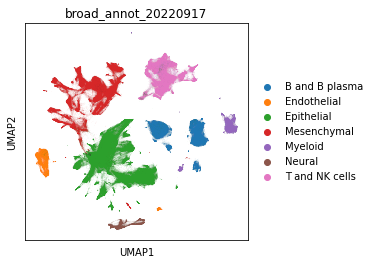

In [24]:
sc.pl.umap(adata,color='broad_annot_20220917')

In [26]:
adata.obsm['X_scANVI'] = pd.read_csv("/home/jupyter/Annotations_v3/models/scanvi_20230126/pooled_healthy.scanvi_broad_annot.X_scANVI.20230126.csv.gz", compression='gzip',index_col=0)

In [27]:
adata.obsm['X_scANVI']

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,LV11,LV12,LV13,LV14,LV15,LV16,LV17,LV18,LV19,LV20
index,,,,,,,,,,,,,,,,,,,,
AAACGAATCTCTTGCG-GSM4600896,-0.262764,1.340677,-2.160902,0.069910,0.357158,-0.287108,-0.965917,0.034153,0.520506,-1.790125,-2.397438,0.138315,1.872088,0.020697,1.892465,-1.511135,0.019417,0.131700,-0.495227,-0.556520
AAACGCTAGCGACCCT-GSM4600896,-0.072241,-0.613696,-1.073295,0.022658,-0.044960,-2.545102,2.844645,0.187638,1.874540,0.084587,0.673198,0.001966,1.555422,0.085497,-0.334869,-1.109183,-0.238280,0.009870,1.183070,-0.461780
AAAGAACAGCGACCCT-GSM4600896,-0.186965,0.732935,-3.169084,0.021434,-0.143460,1.466100,-0.358301,0.016458,-0.353812,-1.221823,-2.798178,0.058806,2.864401,0.021629,-0.075594,-1.860333,-0.053360,0.139438,0.201179,0.432220
AAAGGGCAGTCACACT-GSM4600896,-0.214525,0.690759,-1.187455,0.021666,-0.333761,-2.460742,2.626953,0.113892,1.936636,0.166195,0.925668,0.042487,1.396114,0.062435,-0.161051,-1.128958,-0.226845,0.067524,1.113563,-0.178845
AAAGGGCCAACACAGG-GSM4600896,-0.132387,0.666024,-2.914824,0.050465,-0.749595,-1.104950,0.792894,0.157958,-1.469138,0.220614,-0.774842,0.057308,3.286594,0.115430,0.791877,1.670156,-0.374083,0.084604,3.532067,-0.859793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGAACAACT-GSM5525958,-0.082769,0.065547,0.018543,0.025168,0.171616,0.287131,0.165565,0.105013,2.332270,0.280057,-1.596661,0.070707,1.596012,-0.017695,-0.493651,1.424329,-0.008835,0.028931,0.241978,0.316227
TTTGTCAAGATAGGAG-GSM5525958,-0.089325,0.314489,0.136367,-0.003346,-0.200382,0.061592,0.648185,0.115966,-1.006780,0.291699,2.153949,-0.020209,1.295467,-0.091060,-0.919412,0.742865,0.037235,0.024060,0.007070,-0.251480
TTTGTCAAGTAGGCCA-GSM5525958,-0.132377,0.496524,0.069856,-0.000387,-0.512903,-0.079071,0.597407,0.104690,-1.041012,0.328690,1.783911,-0.035832,1.460910,-0.092021,-0.789184,1.106185,-0.010677,0.053218,-0.306778,-0.069698


In [35]:
scvi_ref = scvi.model.SCVI.load("/home/jupyter/Annotations_v3/scvi_output20230126/pooled_healthy.hvg7500_noCC.nodoublets.scvi_output.20230126.vae/",adata)

INFO     File /home/jupyter/Annotations_v3/scvi_output20230126/pooled_healthy.hvg7500_noCC.no
         doublets.scvi_output.20230126.vae/model.pt already downloaded                       


# Process

## Query

In [28]:
disease_ad = sc.read('/home/jupyter/Annotations_v3/h5ad/disease/Epi.pooled_disease_with_klennerman_ramnik.log1pcounts.20230221.h5ad')

In [29]:
disease_ad

AnnData object with n_obs × n_vars = 311277 × 18485
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

In [31]:
disease_ad.obs.study.value_counts()

Kong2023           251924
Kim2022             26308
Lee2020             11362
Parikh2019           5717
Elmentaite2021       5501
Martin2019           3645
Jeong2021            3073
Fitzpatrick2023      2484
Huang2019            1060
Uzzan2022             129
Kinchen2018            47
Jaeger2021             27
Name: study, dtype: int64

In [32]:
disease_ad = disease_ad[disease_ad.obs.study.isin(['Kong2023','Fitzpatrick2023'])].copy()

In [33]:
disease_ad

AnnData object with n_obs × n_vars = 254408 × 18485
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

In [36]:
scvi.model.SCANVI.prepare_query_anndata(disease_ad, scvi_ref)

INFO     Found 66.71703296703296% reference vars in query data.                              


/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/model/base/_archesmixin.py:204: UserWarning: Query data contains less than 1% of reference var names. This may result in poor performance.
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/model/base/_archesmixin.py:211: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_padding = AnnData(


In [37]:
disease_ad

AnnData object with n_obs × n_vars = 254408 × 7280
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

In [38]:
scanvi_query = scvi.model.SCANVI.load_query_data(
    disease_ad,
    "/home/jupyter/Annotations_v3/models/scanvi_20230126/pooled_healthy.broad_annot_20220817.scanvi_model.pt",
)

INFO     File /home/jupyter/Annotations_v3/models/scanvi_20230126/pooled_healthy.broad_annot_
         20220817.scanvi_model.pt/model.pt already downloaded                                


/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:89: UserWarning: Missing labels key broad_annot_20220917. Filling in with unlabeled category Unknown.
  warnings.warn(


In [42]:
scanvi_query.train(
    max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10
)

INFO     Training for 100 epochs.                                                            


/opt/conda/envs/scvi/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [56:10<00:00, 33.70s/it, loss=832, v_num=1]


In [44]:
scanvi_query.save(
    "/home/jupyter/Annotations_v3/models/scanvi_output20230126/pooled_healthy_broad_annot.diseaseRAMNIKKLENERMAN_scanvi_model.pt"
)

In [45]:
disease_ad.obsm["X_scANVI"] = scanvi_query.get_latent_representation()

In [46]:
pd.DataFrame(
    disease_ad.obsm["X_scANVI"],
    index=disease_ad.obs_names,
    columns=[f"LV{i+1}" for i in range(disease_ad.obsm["X_scANVI"].shape[1])],
).to_csv(
    "/home/jupyter/Annotations_v3/models/disease_ramnik_klennerman_latentspace_fullreferenceprojection_20230227.csv.gz"
)